### <p style="font-family:JetBrains Mono; font-weight:bold; letter-spacing: 2px; color:#294B8E; font-size:140%; text-align:left; padding: 0px; border-bottom: 3px solid #294B8E">Прогнозирование спроса</p>

<a id="1.2"></a>
<div style="padding:20px;
             color:white;
             margin:10;
             font-size:170%;
             text-align:left;
             display:fill;
             border-radius:5px;
             background-color:#294B8E;
             overflow:hidden;
             font-weight:700"><span style='color:#CDA63A'>|</span> Содержание</div>

<div class="toc"><ul class="toc-item"><li><span><a href="#Описание-данных" data-toc-modified-id="Описание-данных-1"> <span class="toc-item-num">1&nbsp;&nbsp;</span>Описание данных</a></span></li>
     <li><span><a href="#Загрузка-библиотек" data-toc-modified-id="Загрузка-библиотек-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Загрузка библиотек</a></span></li>
     <li><span><a href="#EDA" data-toc-modified-id="EDA-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>EDA</a></span></li>
     <li><span><a href="#Анализ-данных" data-toc-modified-id="Анализ-данных-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Анализ данных</a></span></li>

<a id="Описание-данных"></a>
<div style="padding:20px;
             color:white;
             margin:10;
             font-size:170%;
             text-align:left;
             display:fill;
             border-radius:5px;
             background-color:#294B8E;
             overflow:hidden;
             font-weight:700"><span style='color:#CDA63A'>|</span> Описание данных</div>

### 1) sales_df_train.csv –данные по продажам за скользящий год для обучения.

<ul>
<li>st_id – захэшированное id магазина;</li>
<li>pr_sku_id – захэшированное id товара;</li>
<li>date – дата;</li>
<li>pr_sales_type_id – флаг наличия промо;</li>
<li>pr_sales_in_units – число проданных товаров всего (промо и без);</li>
<li>pr_promo_sales_in_units – число проданных товаров с признаком промо;</li>
<li>pr_sales_in_rub – продажи в РУБ всего (промо и без);</li>
<li>pr_promo_sales_in_rub – продажи с признаком промо в РУБ;</li>
</ul>

### 2) pr_df.csv – данные по товарной иерархии.
От большего к меньшему pr_group_id - pr_cat_id - pr_subcat_id - pr_sku_id.
<ul>
<li>pr_group_id – захэшированная группа товара;</li>
<li>pr_cat_id – захэшированная категория товара;</li>
<li>pr_subcat_id – захэшированная подкатегория товара;</li>
<li>pr_sku_id – захэшированное id товара;</li>
<li>pr_uom_id (маркер, обозначающий продаётся товар на вес или в ШТ).</li>
</ul>

### 3) pr_st.csv – данные по магазинам.
<ul>
<li>st_id – захэшированное id магазина;</li>
<li>st_city_id – захэшированное id города;</li>
<li>st_division_code id – захэшированное id дивизиона;</li>
<li>st_type_format_id – id формата магазина;</li>
<li>st_type_loc_id – id тип локации/окружения магазина;</li>
<li>st_type_size_id – id типа размера магазина;</li>
<li>st_is_active – флаг активного магазина на данный момент.</li>
</ul>

### 4) sales_submission.csv – пример файла с результатом работы модели прогноза спроса.
Необходимо подготовить файл в таком же формате, заполнив колонку target предсказаниями (по
умолчанию колонка заполнена нулями).
<ul>
<li>st_id – захэшированное id магазина;</li>
<li>pr_sku_id – захэшированное id товара;</li>
<li>date – дата (день);</li>
<li>target – спрос в ШТ.</li>
</ul>

<div class="alert alert-block alert-info" style="background-color:#FFFAF0;
                                                 color:black;
                                                 border-color:#DEB887;
                                                 border-radius:5px;
                                                 width:50%;
                                                 margin: auto;
                                                 text-align: left;">


Краткое описание:
Необходимо создать алгоритм прогноза спроса на 14 дней для товаров собственного производства. Гранулярность ТК-SKU-День.

Задача:
Построить модель прогноза спроса на основе мастер данных и данных продаж с учетом разных признаков.

Метрика качества:
WAPE

</div>

<a id="Загрузка-библиотек"></a>
<div style="padding:20px;
             color:white;
             margin:10;
             font-size:170%;
             text-align:left;
             display:fill;
             border-radius:5px;
             background-color:#294B8E;
             overflow:hidden;
             font-weight:700"><span style='color:#CDA63A'>|</span> Загрузка библиотек</div>

In [1]:
import pandas as pd 
import numpy as np
import seaborn as sns
import pickle
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
import warnings
warnings.filterwarnings('ignore')
from statsmodels.tsa.seasonal import seasonal_decompose
import phik
from phik.report import plot_correlation_matrix
from sklearn.model_selection import GridSearchCV, train_test_split, TimeSeriesSplit
from catboost import CatBoostRegressor, Pool

<a id="EDA"></a>
<div style="padding:20px;
            color:white;
            margin:10;
            font-size:170%;
            text-align:left;
            display:fill;
            border-radius:5px;
            background-color:#294B8E;
            overflow:hidden;
            font-weight:700"><span style='color:#CDA63A'>|</span> EDA</div>

In [2]:
sales_df_train = pd.read_csv('sales_df_train.csv', parse_dates = ['date'])
shops = pd.read_csv('st_df.csv')
products = pd.read_csv('pr_df.csv')
holiday = pd.read_csv('holidays_covid_calendar.csv')

In [3]:
sales_df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 883015 entries, 0 to 883014
Data columns (total 8 columns):
 #   Column                   Non-Null Count   Dtype         
---  ------                   --------------   -----         
 0   st_id                    883015 non-null  object        
 1   pr_sku_id                883015 non-null  object        
 2   date                     883015 non-null  datetime64[ns]
 3   pr_sales_type_id         883015 non-null  int64         
 4   pr_sales_in_units        883015 non-null  float64       
 5   pr_promo_sales_in_units  883015 non-null  float64       
 6   pr_sales_in_rub          883015 non-null  float64       
 7   pr_promo_sales_in_rub    883015 non-null  float64       
dtypes: datetime64[ns](1), float64(4), int64(1), object(2)
memory usage: 53.9+ MB


In [4]:
shops.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12 entries, 0 to 11
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   st_id              12 non-null     object
 1   st_city_id         12 non-null     object
 2   st_division_code   12 non-null     object
 3   st_type_format_id  12 non-null     int64 
 4   st_type_loc_id     12 non-null     int64 
 5   st_type_size_id    12 non-null     int64 
 6   st_is_active       12 non-null     int64 
dtypes: int64(4), object(3)
memory usage: 800.0+ bytes


In [5]:
products.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2050 entries, 0 to 2049
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   pr_sku_id     2050 non-null   object
 1   pr_group_id   2050 non-null   object
 2   pr_cat_id     2050 non-null   object
 3   pr_subcat_id  2050 non-null   object
 4   pr_uom_id     2050 non-null   int64 
dtypes: int64(1), object(4)
memory usage: 80.2+ KB


<div style="border-radius:10px; border:#DEB887 solid; padding: 15px; background-color: #FFFAF0; font-size:100%; text-align:left">
Уникальное количество товаров

In [6]:
len(sales_df_train['pr_sku_id'].unique())

1991

<div style="border-radius:10px; border:#DEB887 solid; padding: 15px; background-color: #FFFAF0; font-size:100%; text-align:left">
Уникальное количество магазинов

In [7]:
len(sales_df_train['st_id'].unique())

12

In [8]:
holiday = holiday[['date', 'holiday']]
holiday['date'] = pd.to_datetime(holiday['date'], format='%d.%m.%Y')

In [9]:
holiday

,date,holiday
0,2015-01-01,1
1,2015-01-02,1
2,2015-01-03,1
3,2015-01-04,1
4,2015-01-05,1
...,...,...
3648,2024-12-27,0
3649,2024-12-28,1
3650,2024-12-29,1
3651,2024-12-30,0


In [10]:
sales_df_train = sales_df_train.merge(holiday, on='date', how='left')
sales_df_train.sample()

,st_id,pr_sku_id,date,pr_sales_type_id,pr_sales_in_units,pr_promo_sales_in_units,pr_sales_in_rub,pr_promo_sales_in_rub,holiday
506520,fa7cdfad1a5aaf8370ebeda47a1ff1c3,a2f01e8907594a5cc33b21086a702036,2023-01-26,1,5.0,5.0,1280.0,1280.0,0


<div class="alert alert-block alert-info" style="background-color:#FFFAF0;
                                                 color:black;
                                                 border-color:#DEB887;
                                                 border-radius:5px;
                                                 width:50%;
                                                 margin: auto;
                                                 text-align: left;">

<b>✍ Вывод</b>
<ul>
<li>Дубликатов и пропусков не обнаружено.</li>

</ul>
</div> 

<a id="Анализ-данных"></a>
<div style="padding:20px;
            color:white;
            margin:10;
            font-size:170%;
            text-align:left;
            display:fill;
            border-radius:5px;
            background-color:#294B8E;
            overflow:hidden;
            font-weight:700"><span style='color:#CDA63A'>|</span> Анализ данных</div>

<div style="border-radius:10px; border:#DEB887 solid; padding: 15px; background-color: #FFFAF0; font-size:100%; text-align:left">
Объединим данные по магазинам и товарам в одну таблицу для выведения активных магазинов

In [11]:
total = sales_df_train.merge(shops, on='st_id', how='left').merge(products, on='pr_sku_id', how='left')

In [12]:
index_no_active = total.index[total['st_is_active']== 0].tolist()

In [13]:
total= total.drop(index=index_no_active)
total.info()

<class 'pandas.core.frame.DataFrame'>
Index: 882286 entries, 0 to 883014
Data columns (total 19 columns):
 #   Column                   Non-Null Count   Dtype         
---  ------                   --------------   -----         
 0   st_id                    882286 non-null  object        
 1   pr_sku_id                882286 non-null  object        
 2   date                     882286 non-null  datetime64[ns]
 3   pr_sales_type_id         882286 non-null  int64         
 4   pr_sales_in_units        882286 non-null  float64       
 5   pr_promo_sales_in_units  882286 non-null  float64       
 6   pr_sales_in_rub          882286 non-null  float64       
 7   pr_promo_sales_in_rub    882286 non-null  float64       
 8   holiday                  882286 non-null  int64         
 9   st_city_id               882286 non-null  object        
 10  st_division_code         882286 non-null  object        
 11  st_type_format_id        882286 non-null  int64         
 12  st_type_loc_id       

In [14]:
total = total.drop(['st_is_active'], axis=1)

In [15]:
total.head()

,st_id,pr_sku_id,date,pr_sales_type_id,pr_sales_in_units,pr_promo_sales_in_units,pr_sales_in_rub,pr_promo_sales_in_rub,holiday,st_city_id,st_division_code,st_type_format_id,st_type_loc_id,st_type_size_id,pr_group_id,pr_cat_id,pr_subcat_id,pr_uom_id
0,c81e728d9d4c2f636f067f89cc14862c,c7b711619071c92bef604c7ad68380dd,2022-10-20,1,5.0,5.0,825.0,825.0,0,908c9a564a86426585b29f5335b619bc,429a86ff6336c144ddaf6144f52ab52c,1,1,8,aab3238922bcc25a6f606eb525ffdc56,28fc2782ea7ef51c1104ccf7b9bea13d,d29b5ce9c2883f0b7e90f79071a2ca82,1
1,42a0e188f5033bc65bf8d78622277c4e,68f441429e73dbd33b81f95da31576e9,2023-01-29,0,4.0,0.0,196.0,0.0,1,b8b4b727d6f5d1b61fff7be687f7970f,da742b3cfca5388aaf9af28a726a3c30,1,1,12,c74d97b01eae257e44aa9d5bade97baf,1bc0249a6412ef49b07fe6f62e6dc8de,68f204f3838bfee4ada868b66e6a0814,17
2,1ecfb463472ec9115b10c292ef8bc986,22988026fe85fde60d8bf777ab6bc3b4,2023-03-02,0,1.0,0.0,78.0,0.0,0,908c9a564a86426585b29f5335b619bc,429a86ff6336c144ddaf6144f52ab52c,2,1,28,c74d97b01eae257e44aa9d5bade97baf,f3173935ed8ac4bf073c1bcd63171f8a,5fd72b9fc7118bd36a137d7cea8c588a,17
3,42a0e188f5033bc65bf8d78622277c4e,8e887cf8e64ab8e7173701a979476567,2023-04-05,1,0.0,0.0,69.0,69.0,0,b8b4b727d6f5d1b61fff7be687f7970f,da742b3cfca5388aaf9af28a726a3c30,1,1,12,aab3238922bcc25a6f606eb525ffdc56,28fc2782ea7ef51c1104ccf7b9bea13d,a13b7a6b8e80d44d044c257a08ecccca,1
4,16a5cdae362b8d27a1d8f8c7b78b4330,e6fc24ca846339d204b0b50e9f772484,2023-02-17,0,1.0,0.0,161.0,0.0,0,c1f75cc0f7fe269dd0fd9bd5e24f9586,296bd0cc6e735f9d7488ebc8fbc19130,1,2,8,c74d97b01eae257e44aa9d5bade97baf,a368b0de8b91cfb3f91892fbf1ebd4b2,0d51481bbf77027ddb2c990cf97cd9dd,1


In [16]:
sales_units_zero = total[total['pr_sales_in_units'] == 0]
print(
    'нулевые продажи в шт и руб:', 
    sales_units_zero[sales_units_zero['pr_sales_in_rub'] == 0]['pr_sales_in_rub'].count(), 
    '\nих доля в данных:', 
    round(sales_units_zero[sales_units_zero['pr_sales_in_rub'] == 0]['pr_sales_in_rub'].count() / total['pr_sales_in_rub'].count() * 100, 2), '%'
)
print(
    'нулевые продажи в шт, но не нулевые в рублях:', 
    sales_units_zero[sales_units_zero['pr_sales_in_rub'] != 0]['pr_sales_in_rub'].count(), 
    '\nих доля в данных:', 
    round(sales_units_zero[sales_units_zero['pr_sales_in_rub'] != 0]['pr_sales_in_rub'].count() / total['pr_sales_in_rub'].count() * 100, 2), '%'
)

нулевые продажи в шт и руб: 453 
их доля в данных: 0.05 %
нулевые продажи в шт, но не нулевые в рублях: 66089 
их доля в данных: 7.49 %


<div style="border-radius:10px; border:#DEB887 solid; padding: 15px; background-color: #FFFAF0; font-size:100%; text-align:left">
В данных имеются записи, которые можно удалить (их доля 0.05%): нулевые значения в количестве проданных товаров и их стоимости

In [17]:
total = total.loc[total['pr_sales_in_units'] != 0]

<div style="border-radius:10px; border:#DEB887 solid; padding: 15px; background-color: #FFFAF0; font-size:100%; text-align:left">
Количество записей со значением целевого признака меньше нуля

In [18]:
print(
    'количество записей возвратов:', 
    total[total['pr_sales_in_units'] < 0]['pr_sales_in_units'].count(), 
    '\nих доля в данных:', 
    round(total[total['pr_sales_in_units'] < 0]['pr_sales_in_units'].count() / total['pr_sales_in_units'].count() * 100, 2), '%'
)

количество записей возвратов: 71 
их доля в данных: 0.01 %


In [19]:
total = total.loc[total['pr_sales_in_units'] > 0]
total.info()

<class 'pandas.core.frame.DataFrame'>
Index: 815673 entries, 0 to 883014
Data columns (total 18 columns):
 #   Column                   Non-Null Count   Dtype         
---  ------                   --------------   -----         
 0   st_id                    815673 non-null  object        
 1   pr_sku_id                815673 non-null  object        
 2   date                     815673 non-null  datetime64[ns]
 3   pr_sales_type_id         815673 non-null  int64         
 4   pr_sales_in_units        815673 non-null  float64       
 5   pr_promo_sales_in_units  815673 non-null  float64       
 6   pr_sales_in_rub          815673 non-null  float64       
 7   pr_promo_sales_in_rub    815673 non-null  float64       
 8   holiday                  815673 non-null  int64         
 9   st_city_id               815673 non-null  object        
 10  st_division_code         815673 non-null  object        
 11  st_type_format_id        815673 non-null  int64         
 12  st_type_loc_id       

<div style="border-radius:10px; border:#DEB887 solid; padding: 15px; background-color: #FFFAF0; font-size:100%; text-align:left">
Проанализируем целевую переменную 'pr_sales_in_units'

In [20]:
total['pr_sales_in_units'].describe()

count    815673.000000
mean          5.451414
std          13.864076
min           1.000000
25%           1.000000
50%           2.000000
75%           5.000000
max        2348.000000
Name: pr_sales_in_units, dtype: float64

<div style="border-radius:10px; border:#DEB887 solid; padding: 15px; background-color: #FFFAF0; font-size:100%; text-align:left">
Cреднее значение больше медианного, наблюдается правосторонняя асимметрия. Распределение целевой переменной 'pr_sales_in_units' отличается от нормального.

<div style="border-radius:10px; border:#DEB887 solid; padding: 15px; background-color: #FFFAF0; font-size:100%; text-align:left">
топ 5 магазинов, лидирующих по продажам

In [21]:
top_five_shops_units_rub = total.pivot_table(
    index='st_id', values=['pr_sales_in_units', 'pr_sales_in_rub'], aggfunc='sum').reset_index().sort_values(by='pr_sales_in_units', ascending=False).head()
top_five_shops_units_rub

,st_id,pr_sales_in_rub,pr_sales_in_units
7,c81e728d9d4c2f636f067f89cc14862c,109308994.0,958883.0
1,16a5cdae362b8d27a1d8f8c7b78b4330,107530403.0,872754.0
3,42a0e188f5033bc65bf8d78622277c4e,90307800.0,725656.0
8,f7e6c85504ce6e82442c770f7c8606f0,75521279.0,673708.0
9,fa7cdfad1a5aaf8370ebeda47a1ff1c3,64282411.0,532039.0


<div style="border-radius:10px; border:#DEB887 solid; padding: 15px; background-color: #FFFAF0; font-size:100%; text-align:left">
топ 5 продуктов, лидирующих по продажам

In [22]:
top_five_products_rub_units = total.pivot_table(
    index='pr_sku_id', values=['pr_sales_in_units', 'pr_sales_in_rub'], aggfunc='sum').reset_index().sort_values(by='pr_sales_in_units', ascending=False).head()
top_five_products_rub_units

,pr_sku_id,pr_sales_in_rub,pr_sales_in_units
729,62d4af457ba2540ce0898a211c0cd17a,1996443.0,125034.0
1603,ced0c1a84924c982a6403870c54b99ca,3834866.0,121618.0
1480,c0e3f3bd815a862433bc3399c487926b,14904282.0,117922.0
541,4b083e10f6cd2f4360c5425d05be6386,7997036.0,91176.0
1654,d5bfeecaaa47887a4b92d17fa55c2e18,592271.0,81877.0


In [23]:
categ_cols = [
    'st_id', 'pr_sales_type_id', 'st_city_id', 'st_division_code', 
    'st_type_format_id', 'st_type_loc_id', 'st_type_size_id',
    'pr_group_id', 'pr_cat_id', 'pr_subcat_id', 'pr_sku_id', 'pr_uom_id']
phik_overview = total[categ_cols].phik_matrix();

interval columns not set, guessing: ['pr_sales_type_id', 'st_type_format_id', 'st_type_loc_id', 'st_type_size_id', 'pr_uom_id']


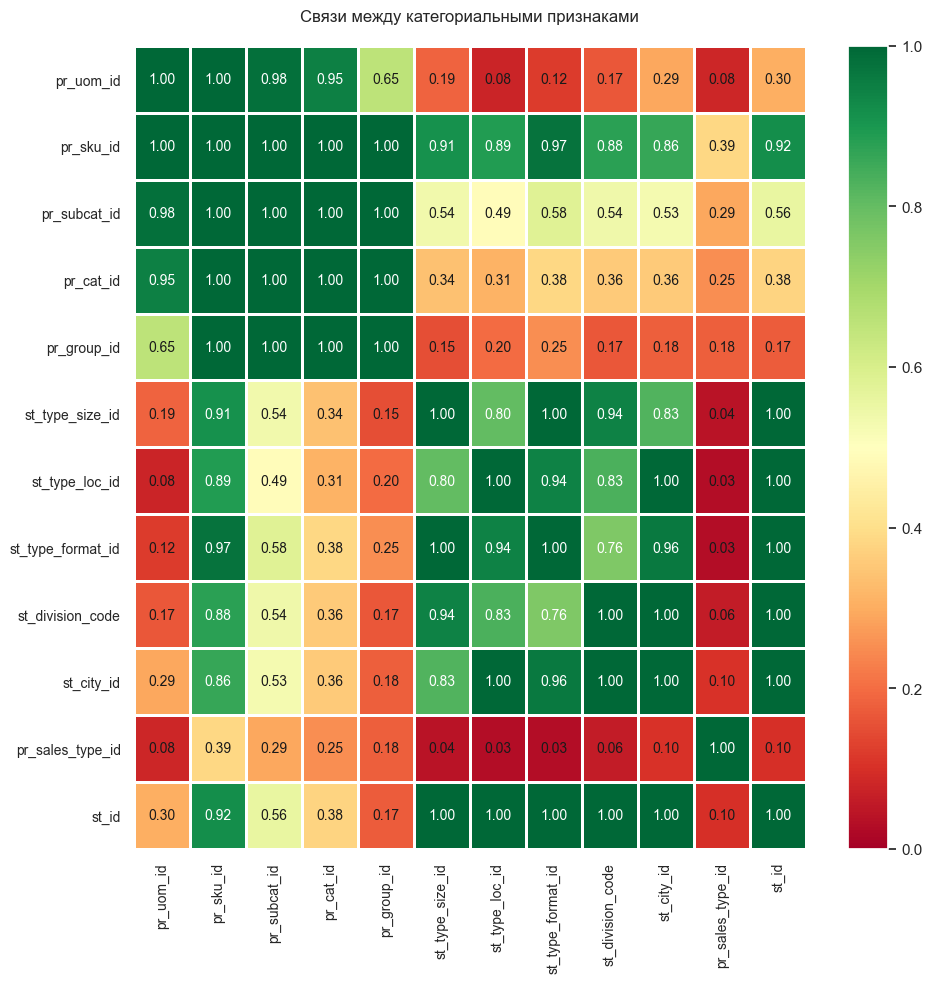

In [24]:
sns.set()
plot_correlation_matrix(phik_overview.values, 
                        x_labels=phik_overview.columns, 
                        y_labels=phik_overview.index, 
                        vmin=0, vmax=1, 
                        fontsize_factor=1.0, figsize=(10, 10))

plt.title('Связи между категориальными признаками', fontsize=12, y=1.02)
plt.tight_layout()

<div style="border-radius:10px; border:#DEB887 solid; padding: 15px; background-color: #FFFAF0; font-size:100%; text-align:left">
Наблюдается сильная зависимость между категориальными признаками, что вполне логично.

In [25]:
quant_cols = ['pr_sales_in_units', 'pr_promo_sales_in_units', 'pr_sales_in_rub', 'pr_promo_sales_in_rub']
phik_overview_q = total[quant_cols].phik_matrix();

interval columns not set, guessing: ['pr_sales_in_units', 'pr_promo_sales_in_units', 'pr_sales_in_rub', 'pr_promo_sales_in_rub']


In [26]:
phik_overview.columns

Index(['st_id', 'pr_sales_type_id', 'st_city_id', 'st_division_code',
       'st_type_format_id', 'st_type_loc_id', 'st_type_size_id', 'pr_group_id',
       'pr_cat_id', 'pr_subcat_id', 'pr_sku_id', 'pr_uom_id'],
      dtype='object')

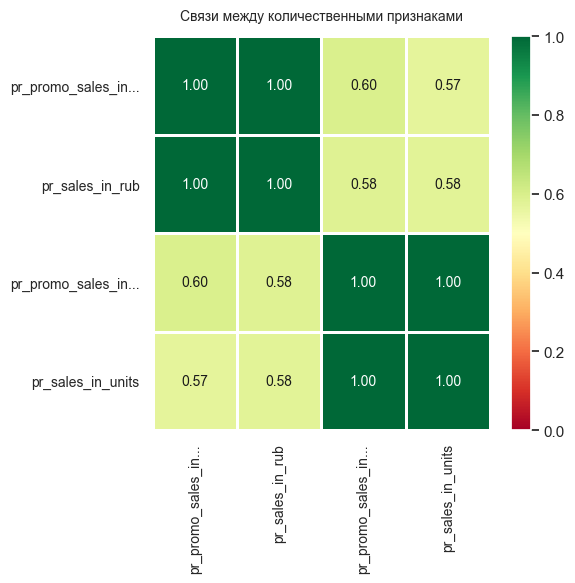

In [27]:
sns.set()
plot_correlation_matrix(phik_overview_q.values, 
                        x_labels=phik_overview_q.columns, 
                        y_labels=phik_overview_q.index, 
                        vmin=0, vmax=1, 
                        fontsize_factor=1.0, figsize=(6, 6))

plt.title('Связи между количественными признаками', fontsize=10, y=1.02)
plt.tight_layout()

<div style="border-radius:10px; border:#DEB887 solid; padding: 15px; background-color: #FFFAF0; font-size:100%; text-align:left">
Устанавливаем столбец с датой в качестве индекса

In [28]:
total = total.drop(['pr_promo_sales_in_units', 'pr_promo_sales_in_rub'], axis=1)

In [29]:
holiday_1_units = total[total['holiday'] == 1]['pr_sales_in_units'].sum()
holiday_0_units = total[total['holiday'] == 0]['pr_sales_in_units'].sum()
holiday_1_rub = total[total['holiday'] == 1]['pr_sales_in_rub'].sum()
holiday_0_rub = total[total['holiday'] == 0]['pr_sales_in_rub'].sum()

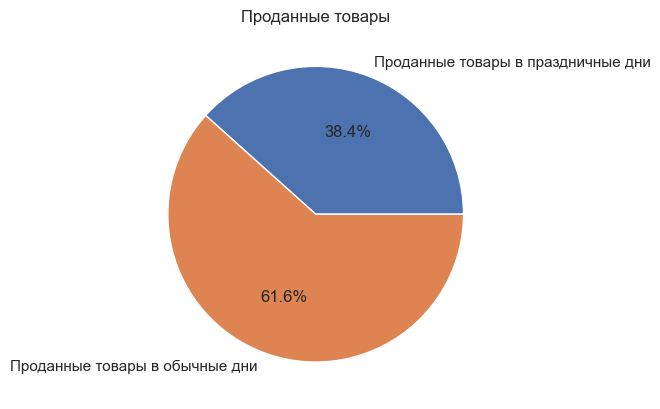

In [30]:
labels = 'Проданные товары в праздничные дни', 'Проданные товары в обычные дни'
sizes = [holiday_1_units, holiday_0_units]
fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%1.1f%%')
plt.title('Проданные товары')
plt.show()

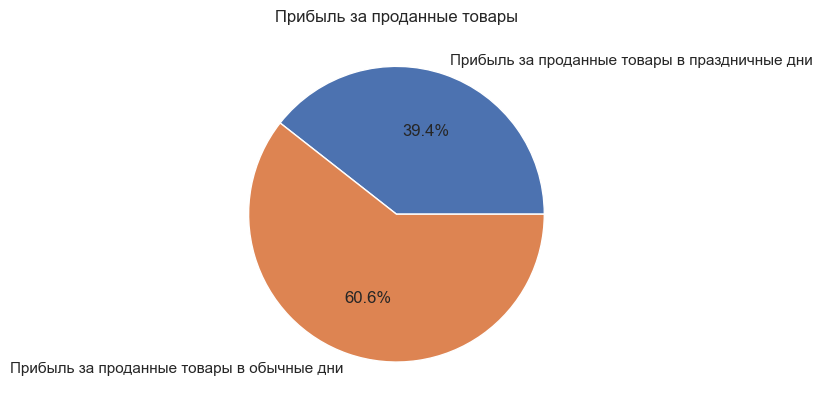

In [31]:
labels = 'Прибыль за проданные товары в праздничные дни', 'Прибыль за проданные товары в обычные дни'
sizes = [holiday_1_rub, holiday_0_rub]
fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%1.1f%%')
plt.title('Прибыль за проданные товары')
plt.show()

In [32]:
total=total.set_index('date')

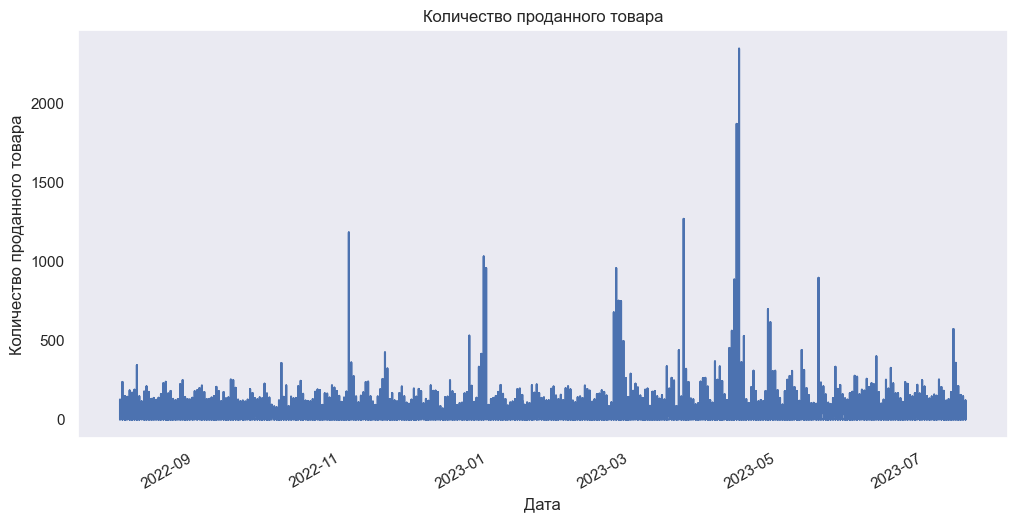

In [33]:
total['pr_sales_in_units'].plot(figsize=(12,6));
plt.title("Количество проданного товара") 
plt.xlabel("Дата") 
plt.ylabel("Количество проданного товара") 
plt.grid();

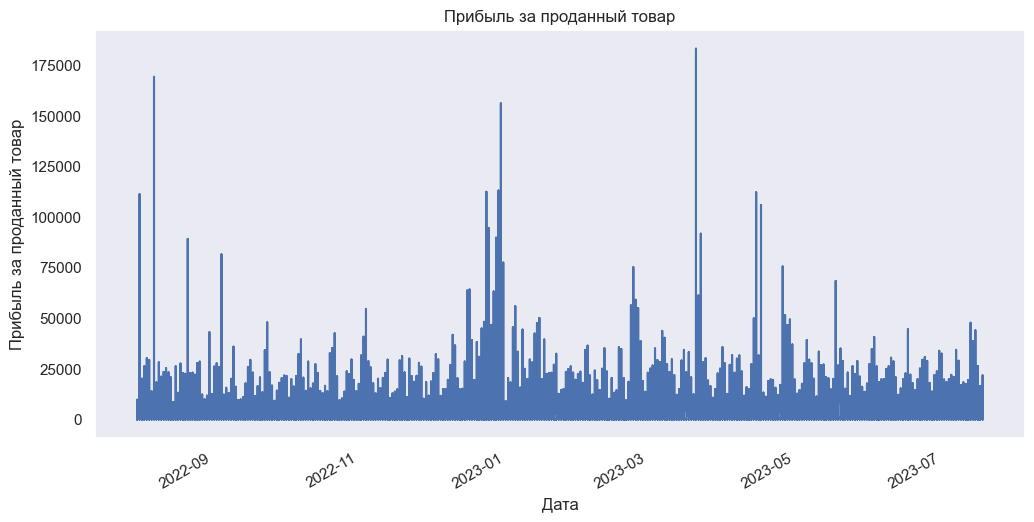

In [34]:
total['pr_sales_in_rub'].plot(figsize=(12,6));
plt.title("Прибыль за проданный товар") 
plt.xlabel("Дата") 
plt.ylabel("Прибыль за проданный товар") 
plt.grid();

<div style="border-radius:10px; border:#DEB887 solid; padding: 15px; background-color: #FFFAF0; font-size:100%; text-align:left">
Построим скользящее среднее

<div style="border-radius:10px; border:#DEB887 solid; padding: 15px; background-color: #FFFAF0; font-size:100%; text-align:left">
Графики среднего значения за 1 день для параметров 'pr_sales_in_units', 'pr_sales_in_rub'

In [35]:
total['mean'] = total['pr_sales_in_units'].rolling(15).mean()

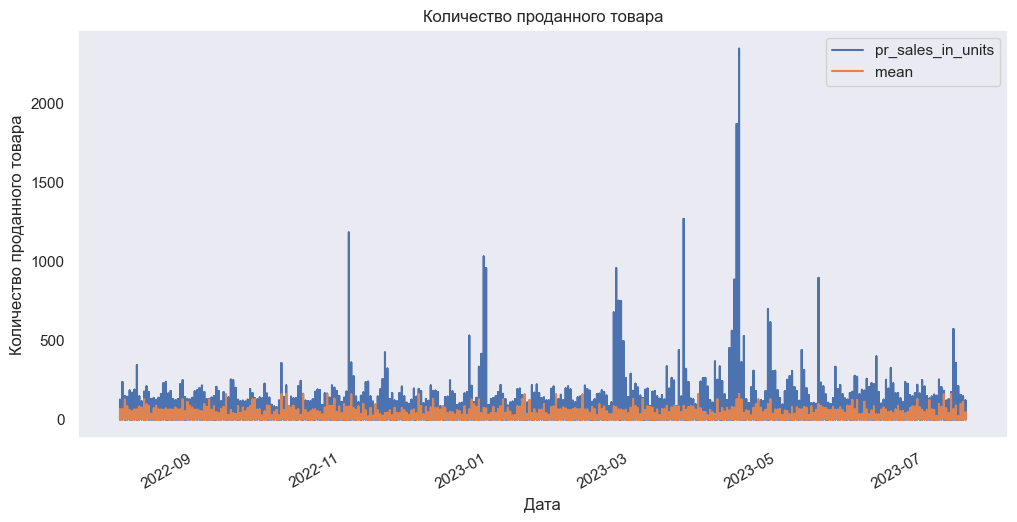

In [36]:
total['pr_sales_in_units'].plot(figsize=(12,6));
total['mean'].plot(figsize=(12,6));
plt.title("Количество проданного товара")
plt.xlabel("Дата")
plt.ylabel("Количество проданного товара")
plt.grid()
plt.legend();

In [37]:
total = total.drop(columns=['mean', 'st_type_size_id', 'pr_subcat_id', 'pr_cat_id', 'st_type_format_id'])

#### Resampling по суммарным значениям за день

In [38]:
total_resamp = total.resample('1D').sum()

#### Графики среднего значения за 1 день для параметров `pr_sales_in_units`, `pr_sales_in_rub`

In [39]:
columns = ['pr_sales_in_units', 'pr_sales_in_rub']

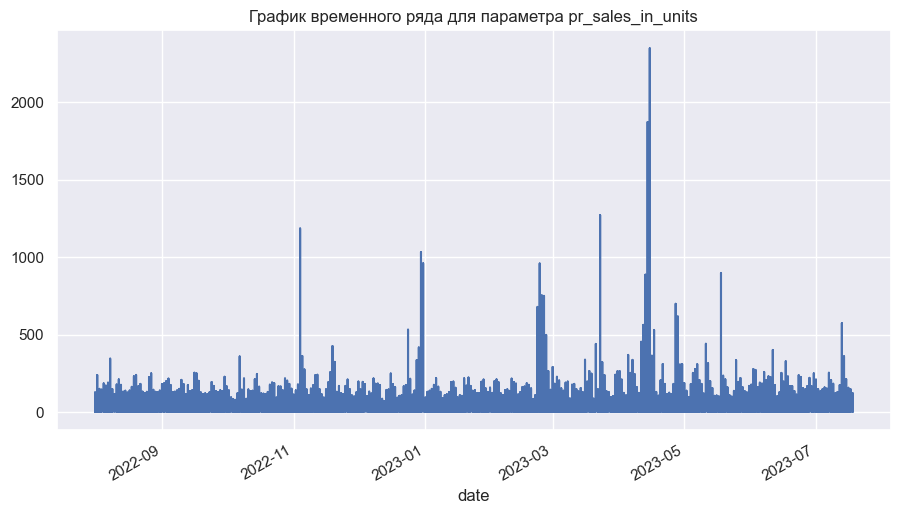

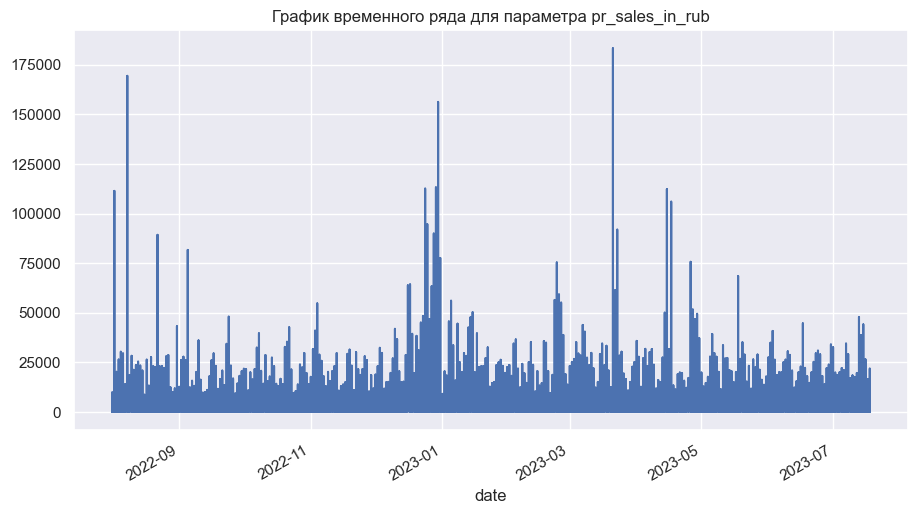

In [40]:
for num in columns:
    fig = plt.figure(figsize=(25,10))
    ax1 = fig.add_subplot(121)
    plot1 = total[num].plot(title= 'График временного ряда для параметра ' +  num)
    plt.subplots_adjust(left=0.1,
                    bottom=0.5,
                    right=0.9,
                    top=0.9,
                    wspace=0.4,
                    hspace=0.9)
    plt.show()

<div style="border-radius:10px; border:#DEB887 solid; padding: 15px; background-color: #FFFAF0; font-size:100%; text-align:left">
Графики среднего значения за 1 день для параметров 'pr_sales_in_units', 'pr_sales_in_rub'

In [41]:
total['rolling_mean_units'] = total['pr_sales_in_units'].rolling(10).mean()
total['rolling_mean_rub'] = total['pr_sales_in_rub'].rolling(10).mean()

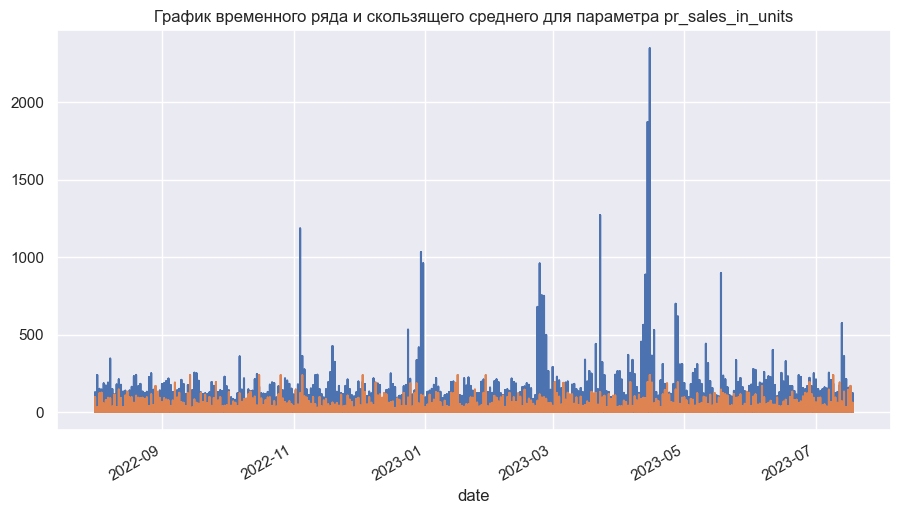

In [42]:
fig = plt.figure(figsize=(25,10))
ax1 = fig.add_subplot(121)
plot1 = total['pr_sales_in_units'].plot(title= 'График временного ряда и скользящего среднего для параметра pr_sales_in_units')
plot2 = total['rolling_mean_units'].plot()
plt.subplots_adjust(left=0.1,
                    bottom=0.5,
                    right=0.9,
                    top=0.9,
                    wspace=0.4,
                    hspace=0.9)
plt.show()


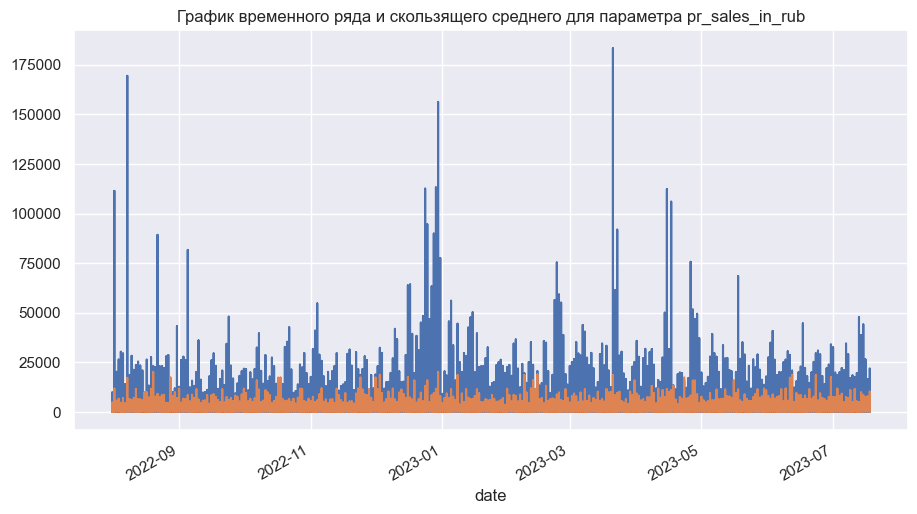

In [43]:
fig = plt.figure(figsize=(25,10))
ax1 = fig.add_subplot(121)
plot1 = total['pr_sales_in_rub'].plot(title= 'График временного ряда и скользящего среднего для параметра pr_sales_in_rub')
plot2 = total['rolling_mean_rub'].plot()
plt.subplots_adjust(left=0.1,
                    bottom=0.5,
                    right=0.9,
                    top=0.9,
                    wspace=0.4,
                    hspace=0.9)
plt.show()

<div style="border-radius:10px; border:#DEB887 solid; padding: 15px; background-color: #FFFAF0; font-size:100%; text-align:left">
Данные имеют сезонность

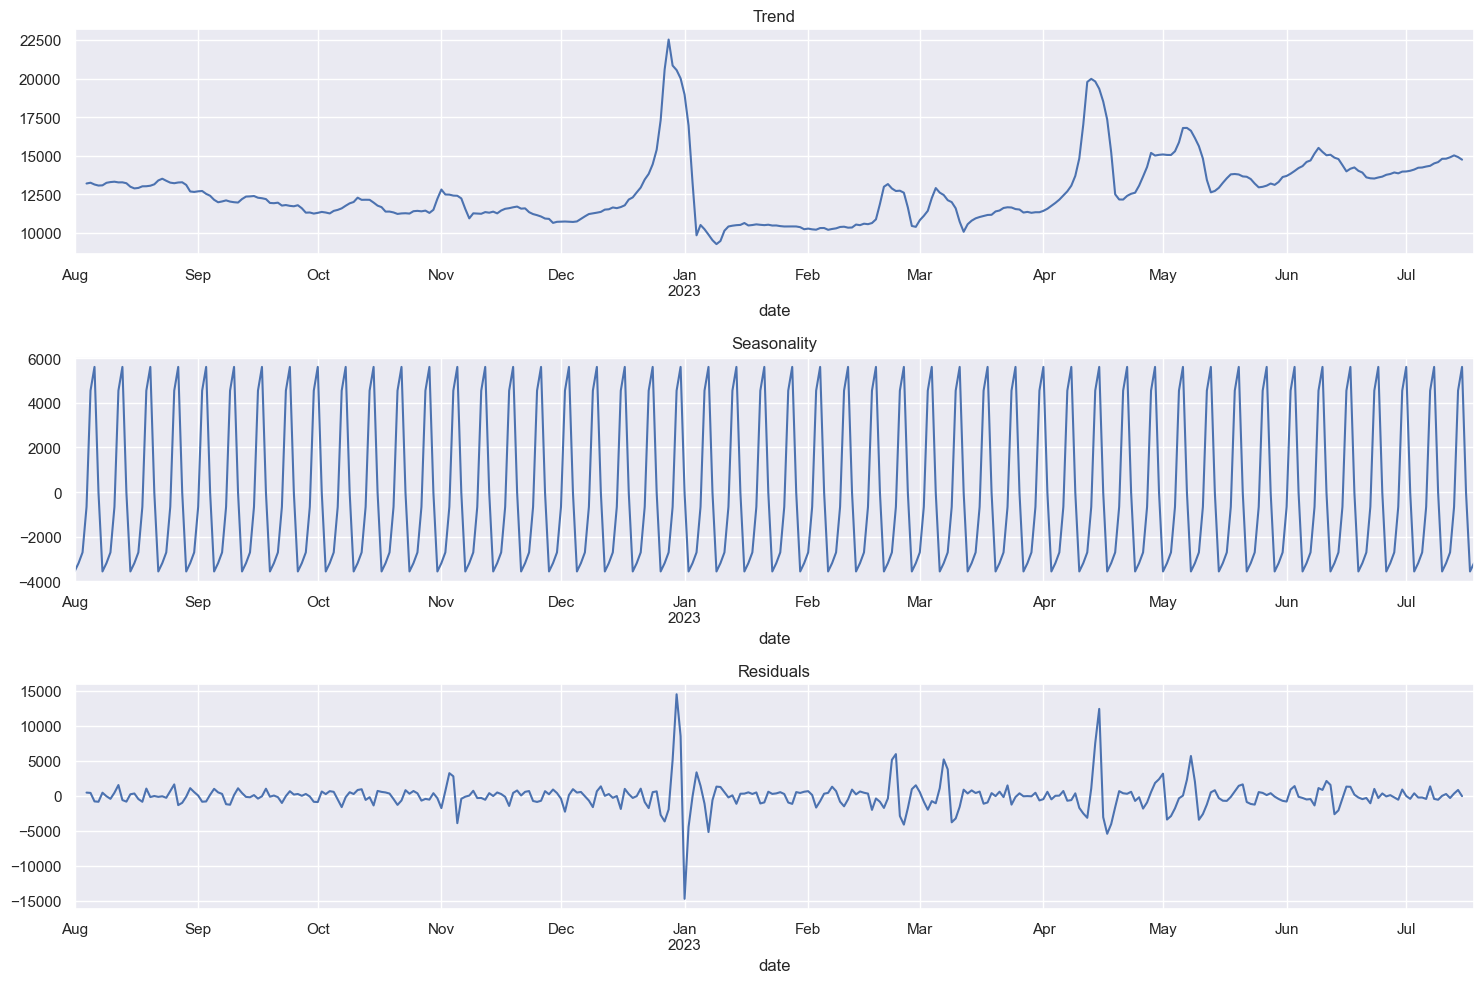

In [44]:
decomposed_units = seasonal_decompose(total_resamp['pr_sales_in_units'])

plt.figure(figsize=(15,10))
plt.subplot(311)

decomposed_units.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed_units.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')
plt.subplot(313)
decomposed_units.resid.plot(ax=plt.gca())
plt.title('Residuals')
plt.tight_layout()

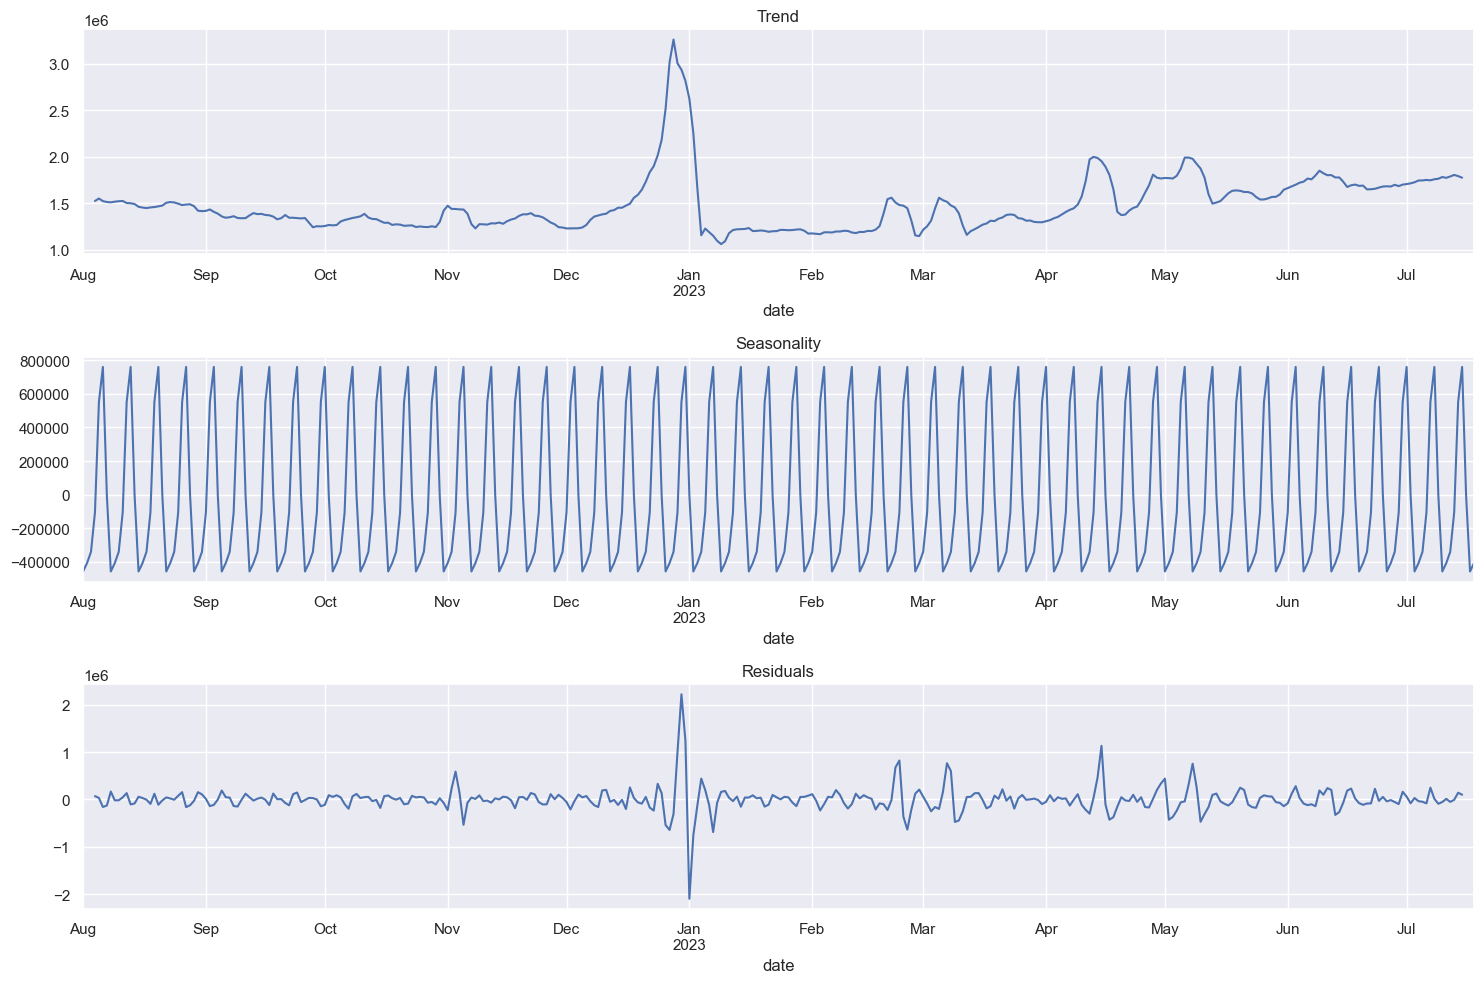

In [45]:
decomposed_rub = seasonal_decompose (total_resamp['pr_sales_in_rub'])

plt.figure(figsize=(15,10))
plt.subplot(311)

decomposed_rub.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed_rub.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')
plt.subplot(313)
decomposed_rub.resid.plot(ax=plt.gca())
plt.title('Residuals')
plt.tight_layout()

<div style="border-radius:10px; border:#DEB887 solid; padding: 15px; background-color: #FFFAF0; font-size:100%; text-align:left">
Изменим интервал и посмотрим данные за 2 недели

In [46]:
data_week = total_resamp['pr_sales_in_rub']
data_week = data_week['2023-06-24':'2023-07-11']
data_week

date
2023-06-24    2397623.0
2023-06-25    1730276.0
2023-06-26    1185828.0
2023-06-27    1259727.0
2023-06-28    1302732.0
2023-06-29    1481514.0
2023-06-30    2414106.0
2023-07-01    2525656.0
2023-07-02    1631366.0
2023-07-03    1299623.0
2023-07-04    1301220.0
2023-07-05    1356392.0
2023-07-06    1562852.0
2023-07-07    2547242.0
2023-07-08    2529817.0
2023-07-09    1669803.0
2023-07-10    1271430.0
2023-07-11    1379081.0
Freq: D, Name: pr_sales_in_rub, dtype: float64

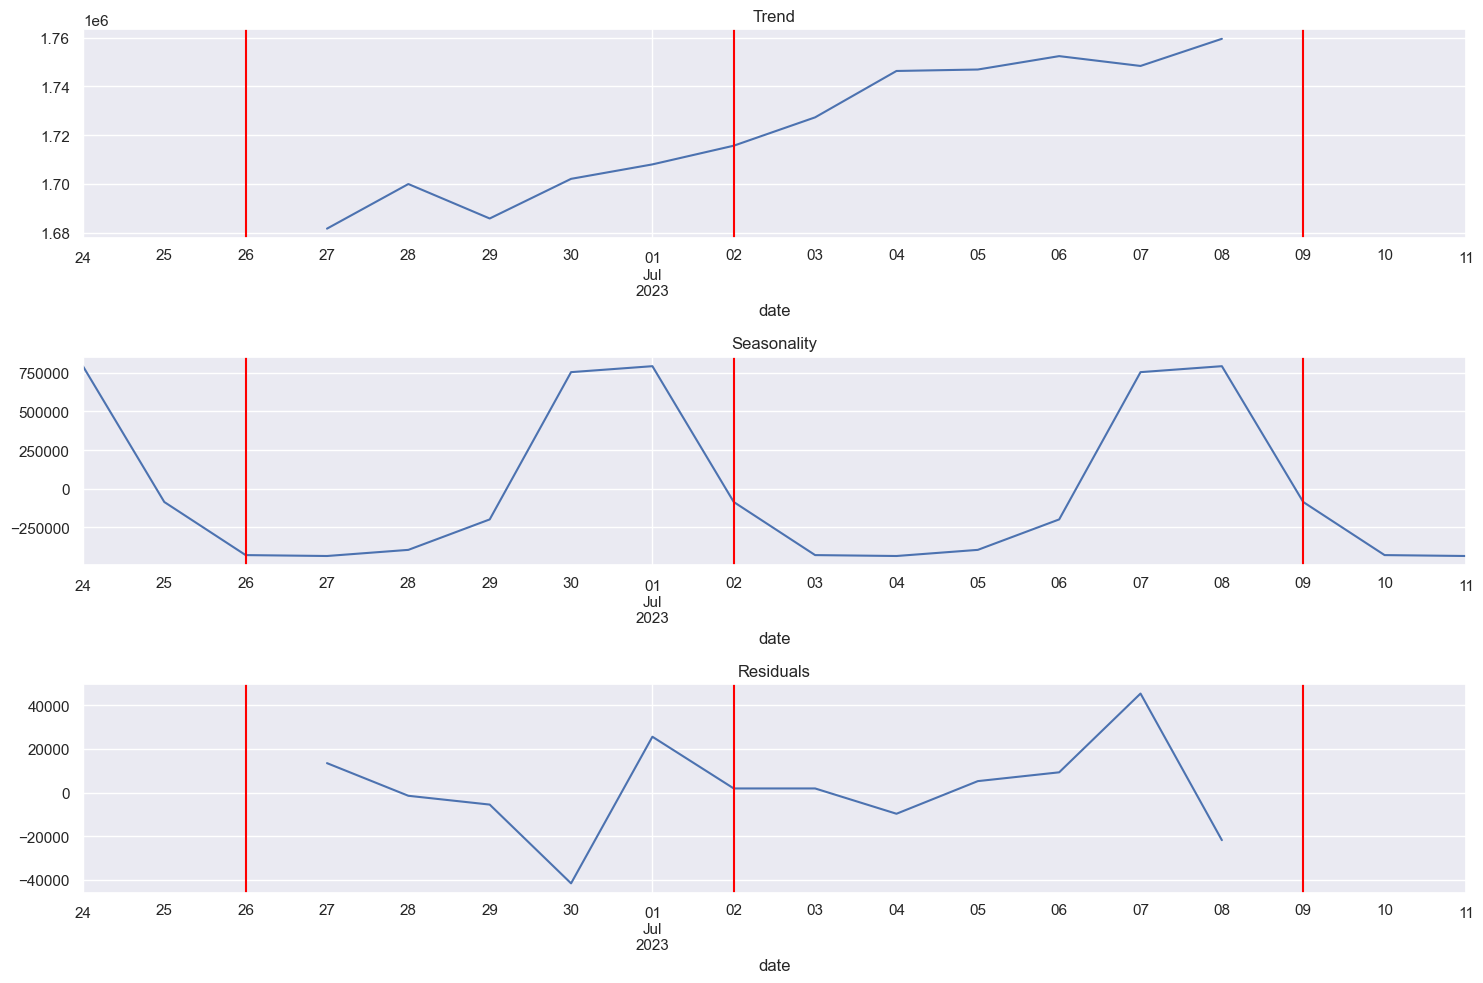

In [47]:
decomposed_week = seasonal_decompose(data_week)

plt.figure(figsize=(15,10))

plt.subplot(311)
decomposed_week.trend.plot(ax=plt.gca())
plt.axvline(x='2023-06-26', color='red', label='axvline - full height')
plt.axvline(x='2023-07-02', color='red', label='axvline - full height')
plt.axvline(x='2023-07-9', color='red', label='axvline - full height')

plt.title('Trend')

plt.subplot(312)
decomposed_week.seasonal.plot(ax=plt.gca())
plt.axvline(x='2023-06-26', color='red', label='axvline - full height')
plt.axvline(x='2023-07-02', color='red', label='axvline - full height')
plt.axvline(x='2023-07-9', color='red', label='axvline - full height')

plt.title('Seasonality')

plt.subplot(313)
decomposed_week.resid.plot(ax=plt.gca())
plt.axvline(x='2023-06-26', color='red', label='axvline - full height')
plt.axvline(x='2023-07-02', color='red', label='axvline - full height')
plt.axvline(x='2023-07-9', color='red', label='axvline - full height')
plt.title('Residuals')
plt.tight_layout()
plt.show()

In [48]:
data_week_1 = total_resamp['pr_sales_in_rub']
data_week_1 = data_week_1['2023-04-02':'2023-04-17']
data_week_1

date
2023-04-02    1405433.0
2023-04-03     844818.0
2023-04-04     992534.0
2023-04-05    1053085.0
2023-04-06    1323514.0
2023-04-07    1851151.0
2023-04-08    2200017.0
2023-04-09    1593239.0
2023-04-10    1002537.0
2023-04-11    1110981.0
2023-04-12    1331255.0
2023-04-13    1930614.0
2023-04-14    2997298.0
2023-04-15    3844080.0
2023-04-16    1784653.0
2023-04-17     921453.0
Freq: D, Name: pr_sales_in_rub, dtype: float64

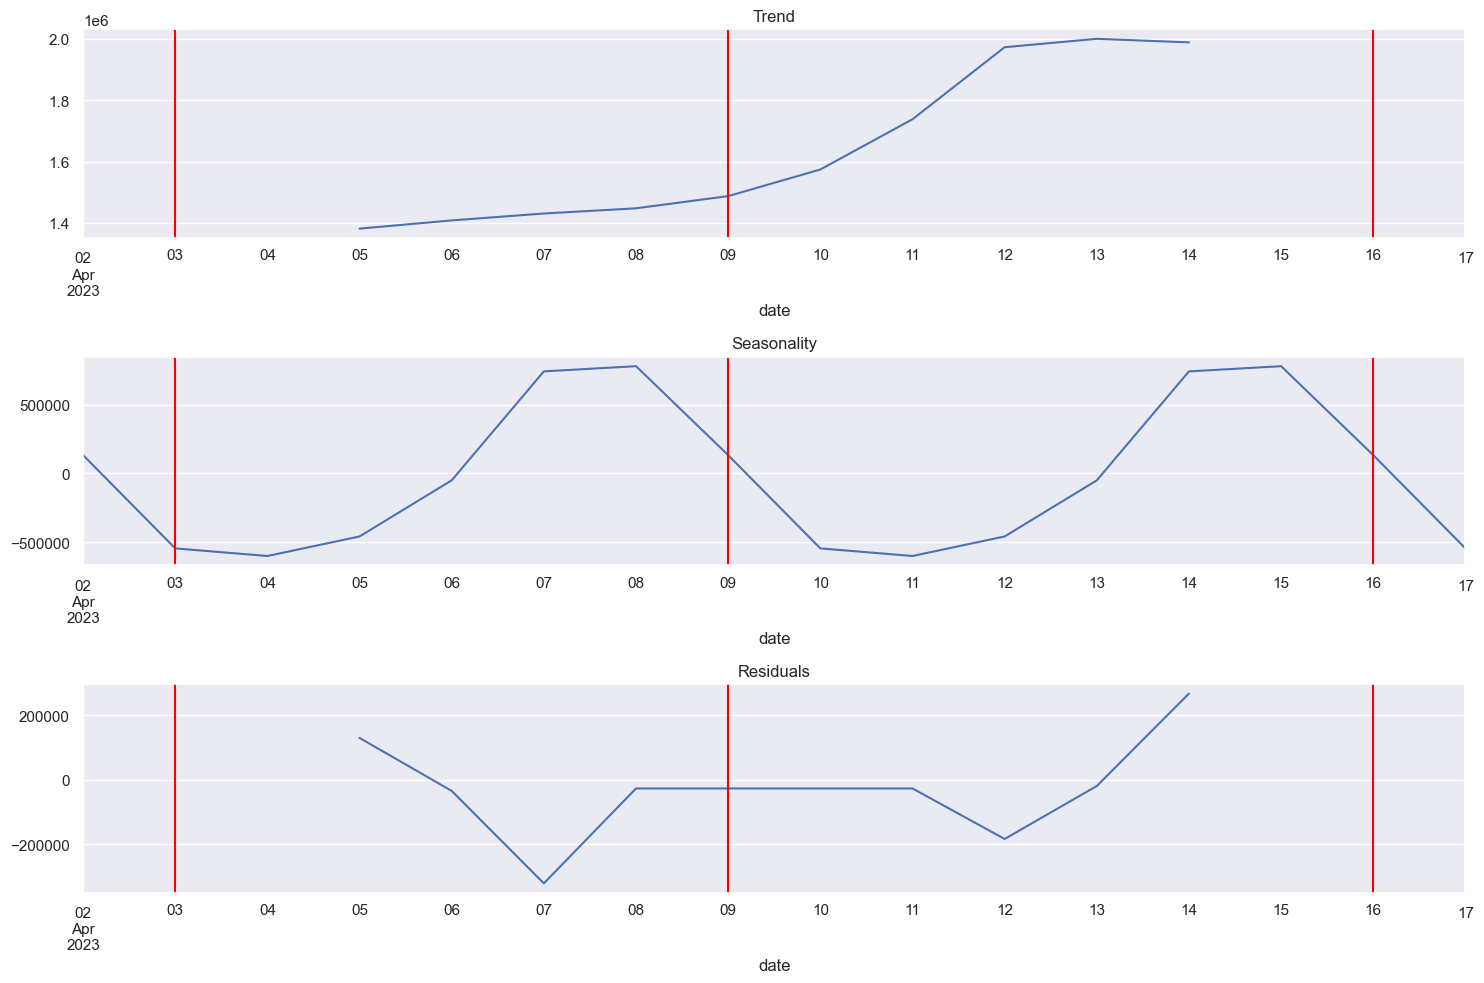

In [49]:
decomposed_week_1 = seasonal_decompose(data_week_1)

plt.figure(figsize=(15,10))
plt.subplot(311)
decomposed_week_1.trend.plot(ax=plt.gca())
plt.axvline(x='2023-04-03', color='red', label='axvline - full height')
plt.axvline(x='2023-04-09', color='red', label='axvline - full height')
plt.axvline(x='2023-04-16', color='red', label='axvline - full height')
plt.title('Trend')

plt.subplot(312)
decomposed_week_1.seasonal.plot(ax=plt.gca())
plt.axvline(x='2023-04-03', color='red', label='axvline - full height')
plt.axvline(x='2023-04-09', color='red', label='axvline - full height')
plt.axvline(x='2023-04-16', color='red', label='axvline - full height')
plt.title('Seasonality')

plt.subplot(313)
decomposed_week_1.resid.plot(ax=plt.gca())
plt.axvline(x='2023-04-03', color='red', label='axvline - full height')
plt.axvline(x='2023-04-09', color='red', label='axvline - full height')
plt.axvline(x='2023-04-16', color='red', label='axvline - full height')
plt.title('Residuals')
plt.tight_layout()
plt.show()

<div style="border-radius:10px; border:#DEB887 solid; padding: 15px; background-color: #FFFAF0; font-size:100%; text-align:left">
На графике тренда видим, что продажи растут в дни государственных праздников: Новый год, 23 февраля, 8 марта, майские праздники, 12 июня. Так же летом продажи выше, чем в остальные времена года.

Продажи резко растут в пятницу и субботу, в воскресенье начинают падать в течении недели спрос маленький. Клиенты чаще совершают покупки перед выходными днями и в выходные.

In [50]:
p_value = adfuller(total_resamp['pr_sales_in_units'])[1]

In [51]:
print('p =', p_value)
if p_value < 0.05:
     print('Нулевая гипотеза отвергается. Ряд стационарен по расширеннему тесту Дики-Фуллера')
else:
     print('Нулевая гипотеза не отвергается. Ряд нестационарен по расширеннему тесту Дики-Фуллера')


p = 0.014722641217042629
Нулевая гипотеза отвергается. Ряд стационарен по расширеннему тесту Дики-Фуллера


#### Удаление признака `pr_sales_type_id`

In [52]:
total = total.drop(['pr_sales_type_id'], axis=1)

#### Удаление пропущенных значений

In [53]:
total = total.dropna()
total = total.sort_values(by='date')

#### Добавление новых признаков

In [54]:
total.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 815664 entries, 2022-08-01 to 2023-07-18
Data columns (total 12 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   st_id               815664 non-null  object 
 1   pr_sku_id           815664 non-null  object 
 2   pr_sales_in_units   815664 non-null  float64
 3   pr_sales_in_rub     815664 non-null  float64
 4   holiday             815664 non-null  int64  
 5   st_city_id          815664 non-null  object 
 6   st_division_code    815664 non-null  object 
 7   st_type_loc_id      815664 non-null  int64  
 8   pr_group_id         815664 non-null  object 
 9   pr_uom_id           815664 non-null  int64  
 10  rolling_mean_units  815664 non-null  float64
 11  rolling_mean_rub    815664 non-null  float64
dtypes: float64(4), int64(3), object(5)
memory usage: 80.9+ MB


In [55]:
total['day'] = total.index

In [56]:
total['month'] = total['day'].dt.month
total['year'] = total['day'].dt.year
total['weekday'] = total['day'].dt.weekday
total['dt'] = total['day']
total['day'] = total['dt'].dt.day
total.head(5)

,st_id,pr_sku_id,pr_sales_in_units,pr_sales_in_rub,holiday,st_city_id,st_division_code,st_type_loc_id,pr_group_id,pr_uom_id,rolling_mean_units,rolling_mean_rub,day,month,year,weekday,dt
date,,,,,,,,,,,,,,,,,
2022-08-01,42a0e188f5033bc65bf8d78622277c4e,49a2be29ab4977d11ce510b2810c3fdb,2.0,259.0,0,b8b4b727d6f5d1b61fff7be687f7970f,da742b3cfca5388aaf9af28a726a3c30,1,aab3238922bcc25a6f606eb525ffdc56,1,4.6,809.1,1,8,2022,0,2022-08-01
2022-08-01,6364d3f0f495b6ab9dcf8d3b5c6e0b01,cfb54b1ce12bb3f9b6b9e2ea0b57414b,2.0,445.0,0,b8b4b727d6f5d1b61fff7be687f7970f,da742b3cfca5388aaf9af28a726a3c30,1,c74d97b01eae257e44aa9d5bade97baf,1,5.1,557.1,1,8,2022,0,2022-08-01
2022-08-01,42a0e188f5033bc65bf8d78622277c4e,b960c6ee5b5efa12e73f810204b561a8,1.0,57.0,0,b8b4b727d6f5d1b61fff7be687f7970f,da742b3cfca5388aaf9af28a726a3c30,1,c74d97b01eae257e44aa9d5bade97baf,17,4.5,601.7,1,8,2022,0,2022-08-01
2022-08-01,f7e6c85504ce6e82442c770f7c8606f0,566f6537c25d40d0b6adec07323e65e8,3.0,83.0,0,3202111cf90e7c816a472aaceb72b0df,32586311f16876abf92901085bd87b99,1,c74d97b01eae257e44aa9d5bade97baf,17,5.7,567.9,1,8,2022,0,2022-08-01
2022-08-01,fa7cdfad1a5aaf8370ebeda47a1ff1c3,ee441af33a59b66a2026b029a24f269a,12.0,1332.0,0,885fe656777008c335ac96072a45be15,296bd0cc6e735f9d7488ebc8fbc19130,1,6512bd43d9caa6e02c990b0a82652dca,1,8.1,547.7,1,8,2022,0,2022-08-01


#### Выделение категориальных и количественных признаков

In [57]:
RS = 42
#возможно, нужно восстановить признак pr_sales_type_id
#категориальные признаки-числа: 'holiday', 'st_type_format_id', 'st_type_loc_id', 'st_type_size_id', 'pr_uom_id'
#cat_features = ['st_type_format_id', 'st_type_loc_id', 'st_division_code', 'st_type_size_id', 'st_id', 'pr_sku_id']#, 'st_city_id', 'pr_group_id', 'pr_cat_id', 'pr_subcat_id', 'pr_uom_id']
num_features = ['rolling_mean_units', 'rolling_mean_rub', 'holiday']
cat_features = ['st_id', 'pr_sku_id']

In [58]:
len(total['st_id'].unique()) #10 +
len(total['pr_sku_id'].unique()) #1972 +
len(total['holiday'].unique()) #2 +
len(total['st_city_id'].unique()) #6
len(total['st_division_code'].unique()) #5 +
#len(total['st_type_format_id'].unique()) #3 +
len(total['st_type_loc_id'].unique()) #3 +
#len(total['st_type_size_id'].unique()) #5 +
len(total['pr_group_id'].unique()) #9
#len(total['pr_cat_id'].unique()) #43
#len(total['pr_subcat_id'].unique()) #165
len(total['pr_uom_id'].unique()) #2
total.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 815664 entries, 2022-08-01 to 2023-07-18
Data columns (total 17 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   st_id               815664 non-null  object        
 1   pr_sku_id           815664 non-null  object        
 2   pr_sales_in_units   815664 non-null  float64       
 3   pr_sales_in_rub     815664 non-null  float64       
 4   holiday             815664 non-null  int64         
 5   st_city_id          815664 non-null  object        
 6   st_division_code    815664 non-null  object        
 7   st_type_loc_id      815664 non-null  int64         
 8   pr_group_id         815664 non-null  object        
 9   pr_uom_id           815664 non-null  int64         
 10  rolling_mean_units  815664 non-null  float64       
 11  rolling_mean_rub    815664 non-null  float64       
 12  day                 815664 non-null  int32         
 13  month        

Выделены категориальные признаки, установлен `random state`, проверено количество уникальных значений в каждом признаке

#### Выделение категориальных и количественных признаков

In [59]:
#возможно, нужно восстановить признак pr_sales_type_id
#категориальные признаки-числа: 'holiday', 'st_type_format_id', 'st_type_loc_id', 'st_type_size_id', 'pr_uom_id'
cat_features = ['st_id', 'pr_sku_id']
num_features = ['rolling_mean_units', 'rolling_mean_rub']

<div class="alert alert-block alert-info" style="background-color:#FFFAF0;
                                                 color:black;
                                                 border-color:#DEB887;
                                                 border-radius:5px;
                                                 width:50%;
                                                 margin: auto;
                                                 text-align: left;">

<b>✍ Вывод</b>
<ul>
<li>Данные предоставлены за период с 01.08.2022 по 18.07.2023</li>
<li>Удалены записи по магазинам без маркера активности (действие согласовано с бизнесом):
им соответствует 729 записей, что составляет 0.08% датасета.</li>
<li>Распределение целевой переменной 'pr_sales_in_units' отличается от нормального.</li>
<li>Удалены данные с нулевыми продажами в шт и руб.</li>
<li>Удалены данные с возвратом товара.<li>
<li>Прибыль за проданные товары и количество проданных товаров в обычные дни, выше чем в праздничные дни.</li>
<li>Удалены сильно коррелированные столбцы.</li>
<li>Данные были ресемплированы по одному дню.
Проанализированы данные по дням недели.</li>
<li>Созданы новые признаки.</li>
<li>Данные разложены на три составляющие: сезонность, тренд и остаток.</li>
<li>Временной ряд стационарен.</li>      
<li>Показаны топ 5 магазинов по проданным товарам и топ 5 продуктов лидирующих в продаже. </li> 
</ul>
</div> 

<a id="Подготовим-выборки-для-обучения-моделей"></a>
<div style="padding:20px;
            color:white;
            margin:10;
            font-size:170%;
            text-align:left;
            display:fill;
            border-radius:5px;
            background-color:#294B8E;
            overflow:hidden;
            font-weight:700"><span style='color:#CDA63A'>|</span> Подготовим выборки для обучения моделей</div>

#### Разделение данных на обучающую и тестовую выборки

In [60]:
X = total.drop(['pr_sales_in_units', 'pr_sales_in_rub',
                'st_city_id', 'pr_group_id', 'pr_uom_id', 'dt'], axis=1)
y = total['pr_sales_in_units']

In [61]:
X_exp = X.drop(['holiday',
                'st_division_code',
                'st_type_loc_id',
                'rolling_mean_units',
                'rolling_mean_rub'], axis=1)

In [62]:
X_train, X_test, y_train, y_test = train_test_split(X_exp, y, shuffle=False, test_size=.1)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((734097, 6), (81567, 6), (734097,), (81567,))

<div class="alert alert-block alert-info" style="background-color:#FFFAF0;
                                                 color:black;
                                                 border-color:#DEB887;
                                                 border-radius:5px;
                                                 width:50%;
                                                 margin: auto;
                                                 text-align: left;">

<b>✍ Вывод</b>
        <ul>
<li>Данные разделены на обучающую, валидационную и тестовую выборки.</li>

</ul>
</div>

<a id="Обучение-моделей"></a>
<div style="padding:20px;
            color:white;
            margin:10;
            font-size:170%;
            text-align:left;
            display:fill;
            border-radius:5px;
            background-color:#294B8E;
            overflow:hidden;
            font-weight:700"><span style='color:#CDA63A'>|</span> Обучение моделей</div>

### <p style="font-family:JetBrains Mono; font-weight:bold; letter-spacing: 2px; color:#294B8E; font-size:140%; text-align:left;padding: 0px; border-bottom: 3px solid #294B8E">CatBoost</p>

#### Кросс-валидатор временных рядов

In [63]:
tscv = TimeSeriesSplit(n_splits=round((X_train.shape[0] / X_test.shape[0]) - 1))

#### Метрика качества `WAPE`

In [64]:
def wape(y_true, y_pred): #y_true: np.array, y_pred: np.array):
    return np.sum(np.abs(y_true-y_pred))/np.sum(np.abs(y_true))

#### Подбор параметров `CatBoost`

In [65]:
model_cbr = CatBoostRegressor(depth=7, l2_leaf_reg=2, learning_rate=0.01, iterations=1000, random_state=RS, verbose=100)

model_cbr.fit(X_train, y_train, cat_features=cat_features)

0:	learn: 13.9827328	total: 161ms	remaining: 2m 40s
100:	learn: 12.8106559	total: 4.11s	remaining: 36.6s
200:	learn: 12.3660972	total: 7.9s	remaining: 31.4s
300:	learn: 12.1551511	total: 11.5s	remaining: 26.7s
400:	learn: 11.9650112	total: 15.4s	remaining: 23.1s
500:	learn: 11.7896549	total: 20s	remaining: 19.9s
600:	learn: 11.6557903	total: 24.4s	remaining: 16.2s
700:	learn: 11.5556662	total: 28.7s	remaining: 12.2s
800:	learn: 11.4555227	total: 33.4s	remaining: 8.29s
900:	learn: 11.3818119	total: 38s	remaining: 4.18s
999:	learn: 11.3193420	total: 42.6s	remaining: 0us


#### Проверка по метрике качества на тестовых данных

In [66]:
#wape(y_test, model_cbc.predict(X_test))
'Показатель wape лучшей модели на тестовой выборке', wape(y_test, model_cbr.predict(X_test))

('Показатель wape лучшей модели на тестовой выборке', 0.6791812168213021)

#### Feature importance

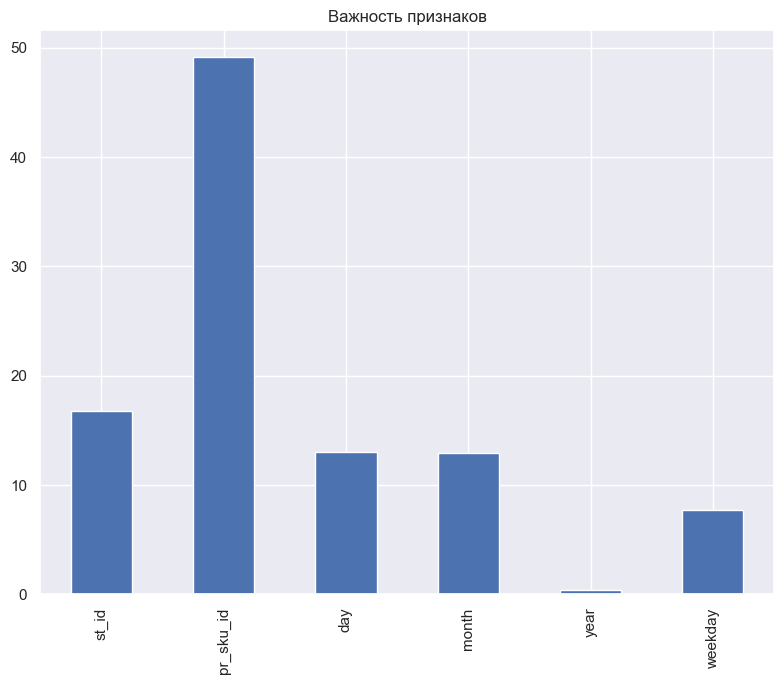

In [67]:
cbr_fi = pd.Series(model_cbr.get_feature_importance(), X_exp.columns)
fig, ax = plt.subplots(figsize=(8,7))
cbr_fi.plot.bar(ax=ax)
ax.set_title("Важность признаков")
fig.tight_layout()

#### Получение предсказания на следующие две недели

In [68]:
sales_submission = pd.read_csv('sales_submission.csv', parse_dates=['date'])
# sales_submission = sales_submission.set_index('date')
# sales_submission = sales_submission.drop('target', axis=1)
# sales_submission.tail()

In [69]:
sales_submission =  sales_submission.merge(holiday, on='date', how='left')
sales_submission.sample()

,st_id,pr_sku_id,date,target,holiday
43617,fa7cdfad1a5aaf8370ebeda47a1ff1c3,d4f898102d7cc1a5eb84579621577da1,2023-08-01,0,0


In [70]:
sales_submission['day'] = sales_submission['date'].dt.day
sales_submission['month'] = sales_submission['date'].dt.month
sales_submission['year'] = sales_submission['date'].dt.year
sales_submission['weekday'] = sales_submission['date'].dt.weekday
#sales_submission = sales_submission.drop(['holiday_y'], axis=1)
sales_submission = sales_submission.set_index('date')
sales_submission.head(5)

,st_id,pr_sku_id,target,holiday,day,month,year,weekday
date,,,,,,,,
2023-07-20,16a5cdae362b8d27a1d8f8c7b78b4330,0045ebdb1069ff4b3dd3efe628c39cd3,0,0,20,7,2023,3
2023-07-20,16a5cdae362b8d27a1d8f8c7b78b4330,00661699f543753ec7e911a64b9fd2f6,0,0,20,7,2023,3
2023-07-20,16a5cdae362b8d27a1d8f8c7b78b4330,0094042bfeae507dc7f62acc8e5ed03a,0,0,20,7,2023,3
2023-07-20,16a5cdae362b8d27a1d8f8c7b78b4330,0169529ff660adcac9b7e354e0c4b882,0,0,20,7,2023,3
2023-07-20,16a5cdae362b8d27a1d8f8c7b78b4330,01e4734745e97e52d3213449e1a05dd7,0,0,20,7,2023,3


In [71]:
y_pred = model_cbr.predict(sales_submission)
y_pred

array([3.01628312, 2.13329239, 6.92279583, ..., 7.16691834, 2.33883937,
       1.17647486])

In [72]:
sales_submission['target'] = y_pred
sales_submission = sales_submission.reset_index()
sales_submission.head()

,date,st_id,pr_sku_id,target,holiday,day,month,year,weekday
0,2023-07-20,16a5cdae362b8d27a1d8f8c7b78b4330,0045ebdb1069ff4b3dd3efe628c39cd3,3.016283,0,20,7,2023,3
1,2023-07-20,16a5cdae362b8d27a1d8f8c7b78b4330,00661699f543753ec7e911a64b9fd2f6,2.133292,0,20,7,2023,3
2,2023-07-20,16a5cdae362b8d27a1d8f8c7b78b4330,0094042bfeae507dc7f62acc8e5ed03a,6.922796,0,20,7,2023,3
3,2023-07-20,16a5cdae362b8d27a1d8f8c7b78b4330,0169529ff660adcac9b7e354e0c4b882,1.457174,0,20,7,2023,3
4,2023-07-20,16a5cdae362b8d27a1d8f8c7b78b4330,01e4734745e97e52d3213449e1a05dd7,6.926579,0,20,7,2023,3


In [73]:
sales_submission['target'] = round(sales_submission['target'], 0)
sales_submission.head()

,date,st_id,pr_sku_id,target,holiday,day,month,year,weekday
0,2023-07-20,16a5cdae362b8d27a1d8f8c7b78b4330,0045ebdb1069ff4b3dd3efe628c39cd3,3.0,0,20,7,2023,3
1,2023-07-20,16a5cdae362b8d27a1d8f8c7b78b4330,00661699f543753ec7e911a64b9fd2f6,2.0,0,20,7,2023,3
2,2023-07-20,16a5cdae362b8d27a1d8f8c7b78b4330,0094042bfeae507dc7f62acc8e5ed03a,7.0,0,20,7,2023,3
3,2023-07-20,16a5cdae362b8d27a1d8f8c7b78b4330,0169529ff660adcac9b7e354e0c4b882,1.0,0,20,7,2023,3
4,2023-07-20,16a5cdae362b8d27a1d8f8c7b78b4330,01e4734745e97e52d3213449e1a05dd7,7.0,0,20,7,2023,3


In [74]:
sales_submission = sales_submission.drop([ 'day', 'month', 'year', 'weekday'], axis=1)

In [75]:
sales_submission = sales_submission[['st_id', 'pr_sku_id', 'date', 'target']]
sales_submission.sample()

,st_id,pr_sku_id,date,target
6167,fa7cdfad1a5aaf8370ebeda47a1ff1c3,d5bfeecaaa47887a4b92d17fa55c2e18,2023-07-21,42.0


#### Сохранение результатов

Сохранение результата предсказания

In [76]:
sales_submission.to_csv('sales_submission_pred.csv', encoding='utf-8')

Запись модели в файл

In [77]:
with open('model_cbr.pkl', 'wb') as f:
  pickle.dump(model_cbr, f)

### Заключение

- Предоставленные данные объединены в единый датафрейм, к ним присоединена информация о праздничных и выходных днях в РФ
- Проведено исследование на корреляцию в признаках, удалены зависимые признаки
- Проведено исследование на сезонность и тренд
- Возникли проблемы при попытке применения техник кодирования, в связи с чем из исследования исключены простые модели ML: линейная регрессия, случайный лес, дерево решений
- Для запуска `ARIMA` недостаточно ресурсов
- Для прогнозирования применена модель градиентного бустинга, т.к. она может одинаково хорошо работает с категориальными и количественными признаками
- При помощи `GridSearch` подобраны оптимальные параметры модели с показателем `wape` на трейне 0.63
- На тестовой выборке показатель `wape` получен 0.59
- Анализ значимости признаков показал, что наиболее важный признак - `roller_means_units` и `pr_sku_id`